### Summary

- Use model to track a particular item

### Imports and Assets

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

URL = r"https://www.dropbox.com/s/ld535c8e0vueq6x/opencv_bootcamp_assets_NB11.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB11.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)  

### Tracking

Tracking is done by two main algorithms
1. Motion model: Predict where the object will be in a future frame
2. Appearance model: Approximates shape of the object (finetune motion model)

Tracking outputs a box (given an initial box) to see if it tracks the object

There are multiple tracking models in OpenCV:
1. BOOSTING
2. MIL
3. KCF
4. CRST
5. TLD (recovers occlusions well; object hiding in a few frames)
6. MEDIANFLOW (good for slow predictable motion)
7. GOTURN (deep-learning; best overall)
8. MOSSE (fastest)

Let's first see the video we'll be using to use the model:

In [7]:
cap = cv2.VideoCapture("race_car.mp4")

while (cap.isOpened()):
    retval, frame = cap.read()
    if retval:
        cv2.imshow('Sample Video', frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

This is a good video because it shows the car in different angles and different lightning which proposes a challengefor the appearance model.

Let's make some functions to show that the model understands what its tracking

In [19]:
video_name = "race_car.mp4"

def draw_rectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)

def display_rectangle(frame, bbox):
    plt.figure(figsize=(20, 8))
    frame_copy = frame.copy()
    draw_rectangle(frame_copy, bbox)
    frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_copy)
    plt.axis("off")

def draw_text(frame, text, loc, color = (50, 160, 50)):
    cv2.putText(frame, text, loc, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

As mentioned there exists a model that was a deep-learning model which is the GOTURN. It works by:
- Having two frames (previous and current)
- Highlight bounding box annotation
- With weights, predict the next motion of object
- Use bounding box to track it indefinitely

Next we setup the tracking models that we can experiment on to use

In [52]:
# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[7]

if tracker_type == "BOOSTING":
    tracker = cv2.legacy.TrackerBoosting.create()
elif tracker_type == "MIL":
    tracker = cv2.legacy.TrackerMIL.create()
elif tracker_type == "KCF":
    tracker = cv2.TrackerKCF.create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT.create()
elif tracker_type == "TLD":
    tracker = cv2.legacy.TrackerTLD.create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv2.legacy.TrackerMedianFlow.create()
elif tracker_type == "GOTURN":
    tracker = cv2.TrackerGOTURN.create()
else:
    tracker = cv2.legacy.TrackerMOSSE.create()

We create a video first that has the model tracking it first

In [53]:
cap = cv2.VideoCapture(video_name)
retval, frame = cap.read()

if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
else:
    print("Video unable to open!")
    sys.exit()

video_model_name = "race_car_" + tracker_type +".mp4"
video_result = cv2.VideoWriter(video_model_name, cv2.VideoWriter_fourcc(*"avc1"), 10, (width, height))

We then define a bounding box around the object of interest in the first frame
- Usually done first with a detection model
- Can be done manually by its pixel coordinates
- Or using some UI to place the bounding box first

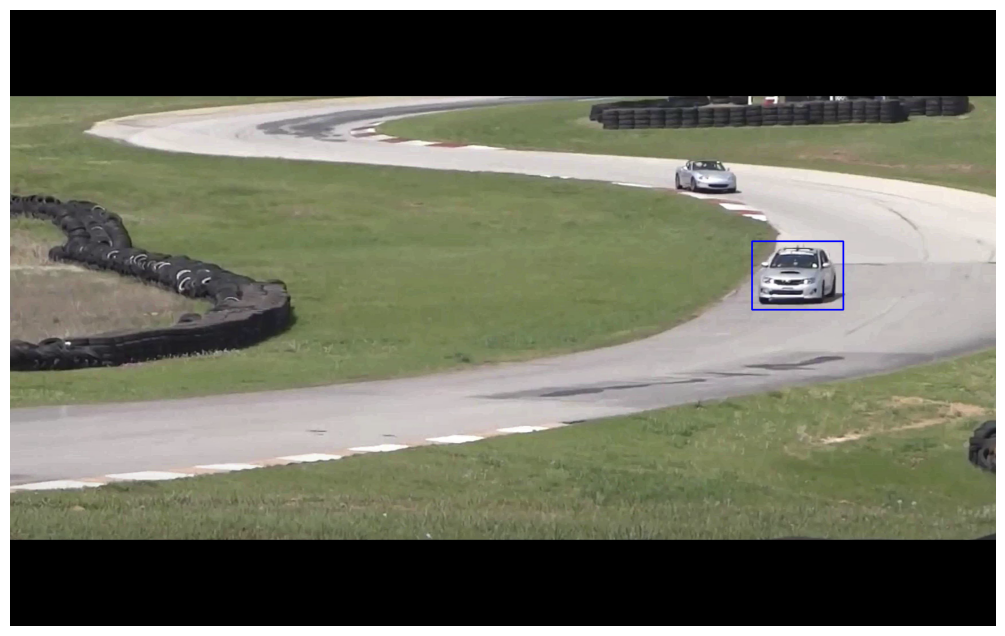

In [54]:
bbox = (1300, 405, 160, 120) # (x, y, how much x to right side, how much y to up side)

display_rectangle(frame, bbox)

Then initialize the tracker with the first frame

In [55]:
# start tracker with first frame
track = tracker.init(frame, bbox)

With the tracker initialized, we track the objcet in the video frame by frame

In [56]:
while True:
    # read original video
    track, frame = cap.read()

    # if frame doesnt exist break
    if not track:
        break

    # update tracker per frame
    track, bbox = tracker.update(frame)

    # draw bounding box
    if track:
        draw_rectangle(frame, bbox)
        draw_text(frame, "car", (int(bbox[0]), int(bbox[1])))
    else:
        draw_text(frame, "Object not detected", (80, 140), (0, 0, 255))
    
    # show info on what tracker is being used
    draw_text(frame, tracker_type + " Tracker", (80, 60))

    # write down box and text into frame
    video_result.write(frame)

cap.release()
video_result.release()